# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

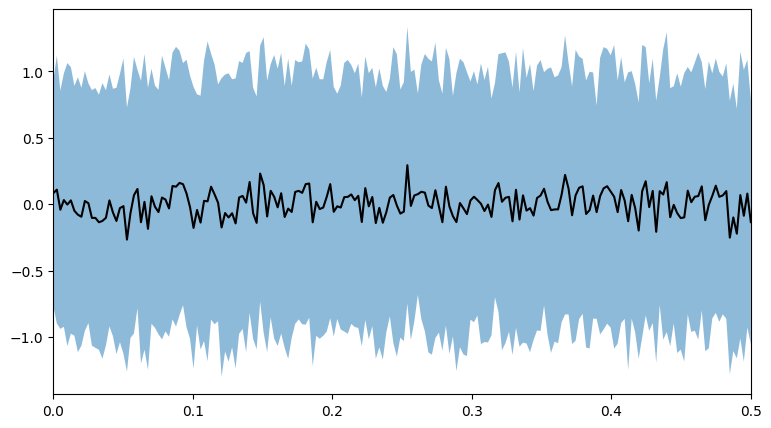

In [3]:

periodograms = np.random.randn(100, 200)  # shape (n_trials, n_freqs)
freqs = np.linspace(0, 0.5, 200)

fig, ax = fig_ax(figsize=(9, 5))

avg = periodograms.mean(axis=0)
std = periodograms.std(axis=0)
ax.plot(freqs, avg, 'k-')
ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)


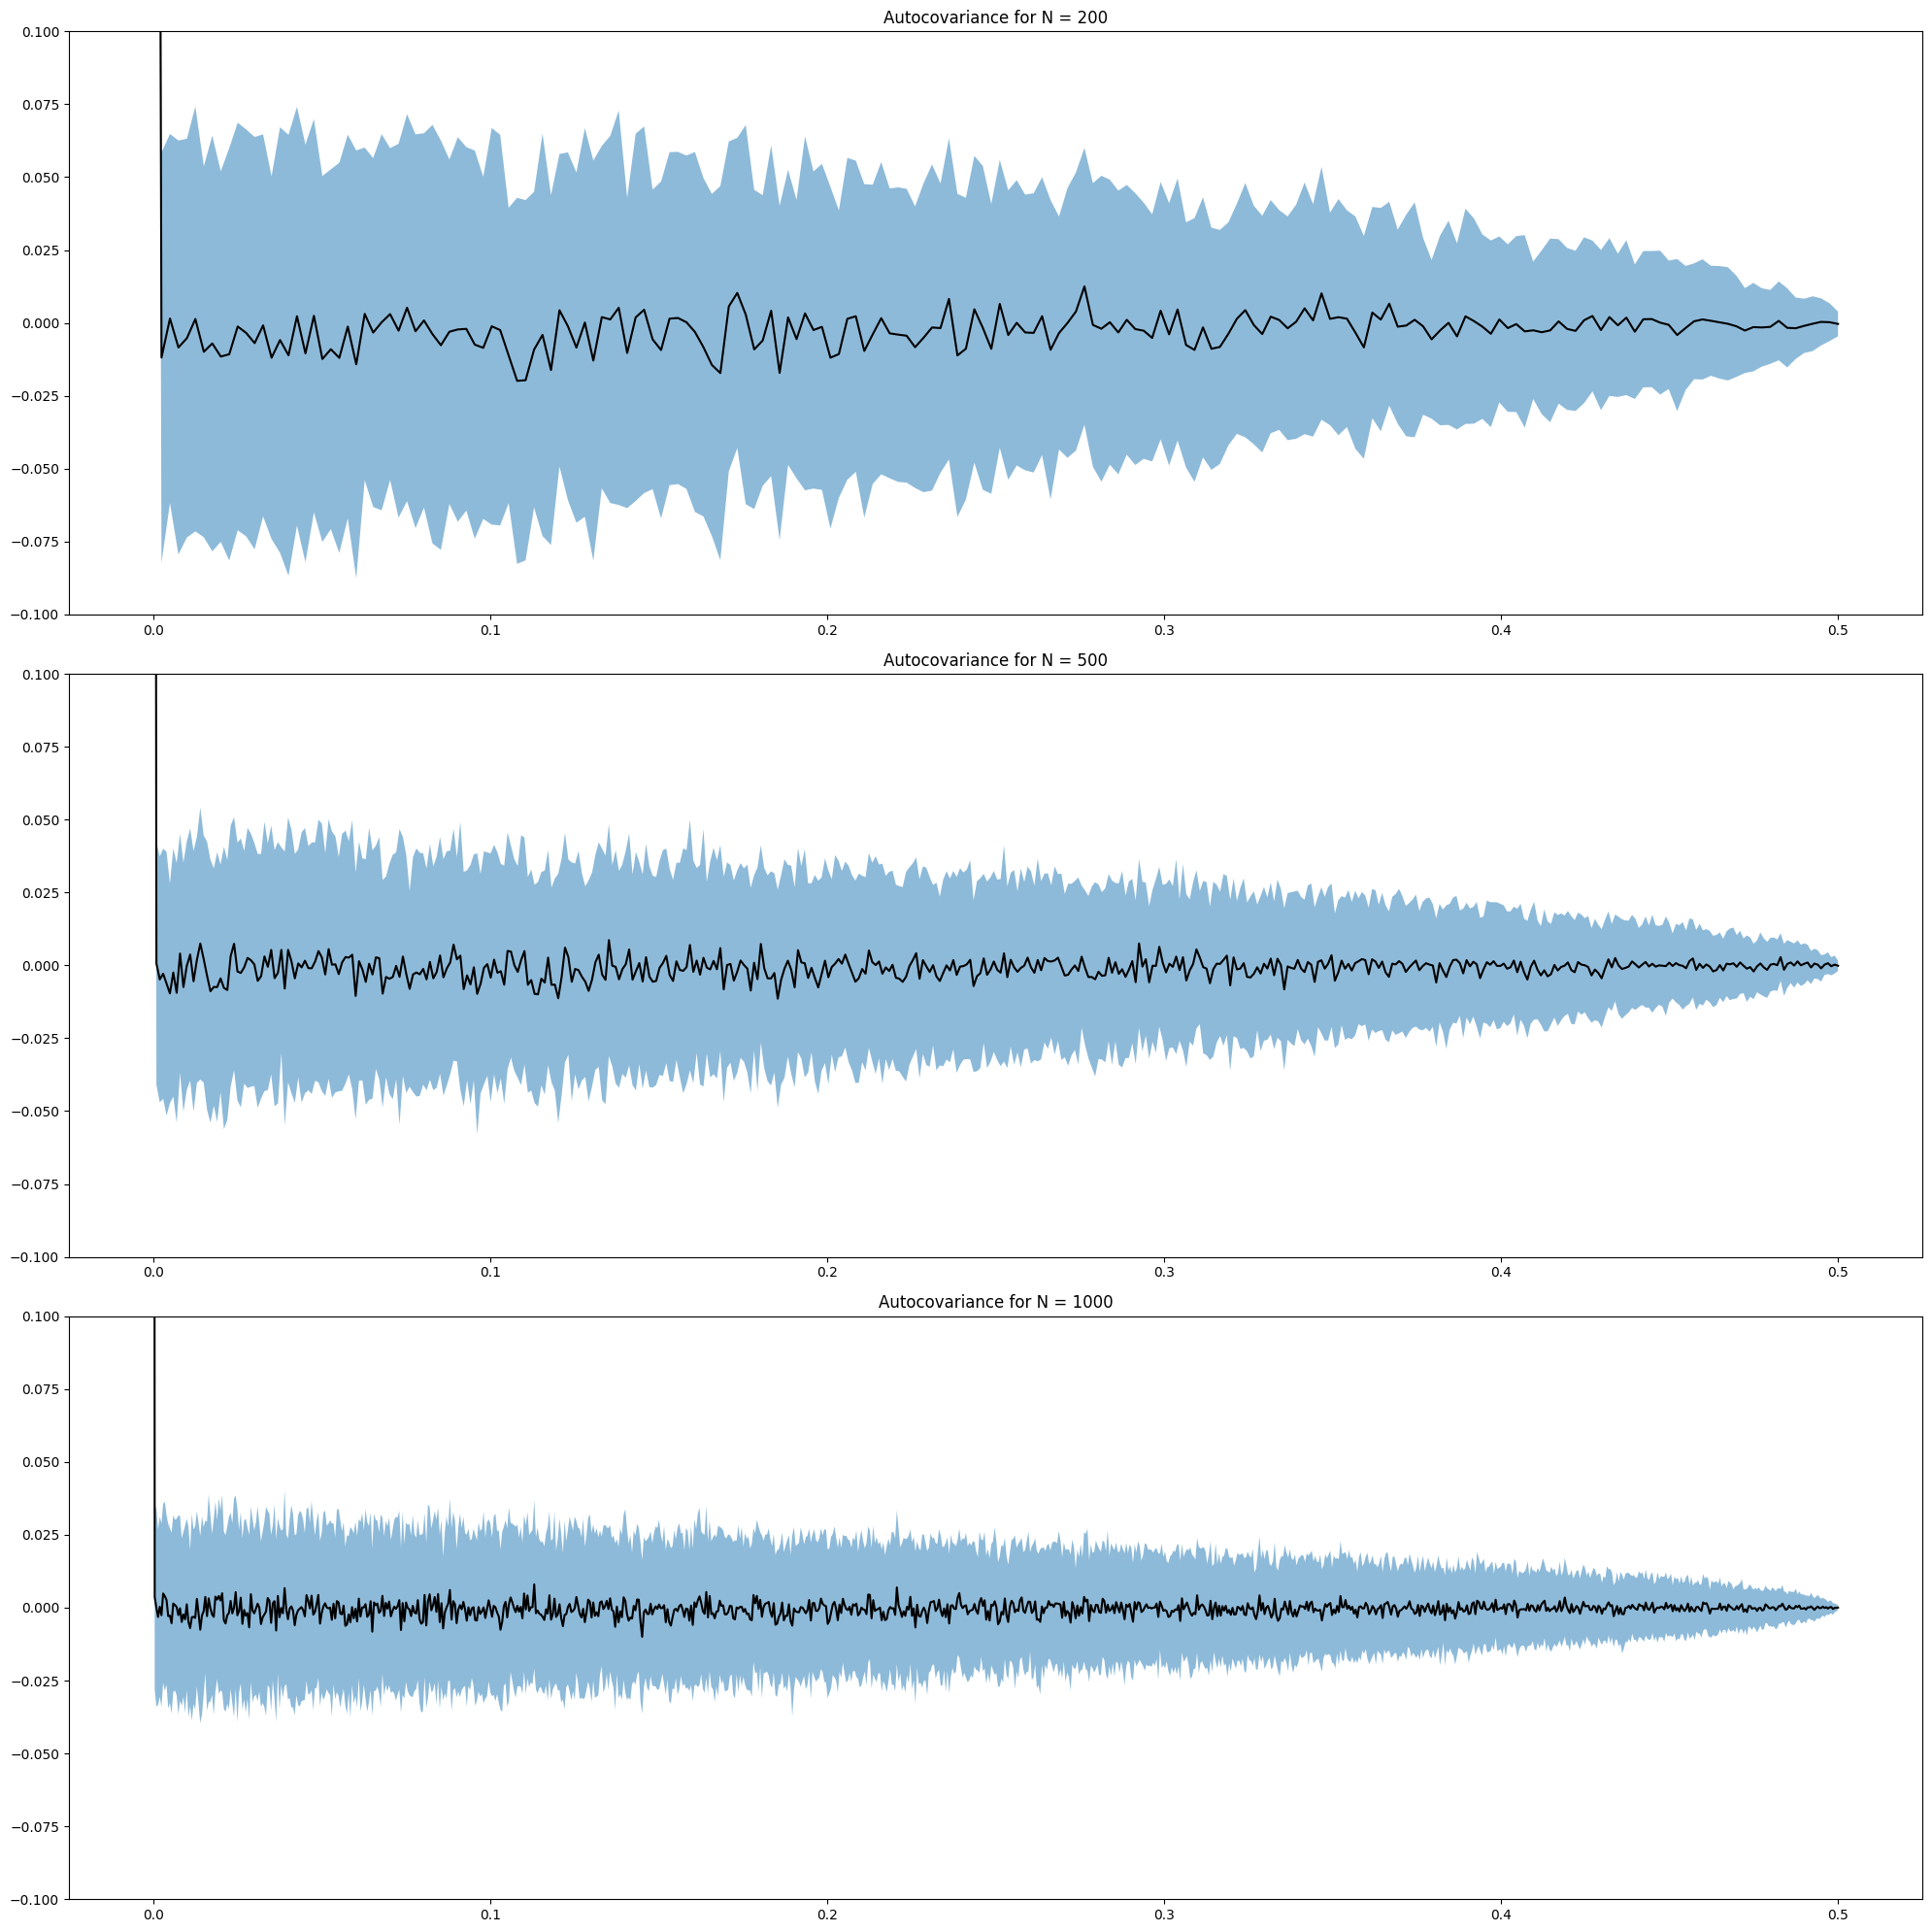

In [4]:
from statsmodels.tsa.stattools import acovf

N = [200, 500, 1000] 
fs = 1
nb_sim = 100 
fig, ax = plt.subplots(3, figsize=(20, 20))

# random data 
for ind, size in enumerate(N) : 
    freqs = np.linspace(0, fs/2, size)
    data = np.random.randn(nb_sim, size) 
    autocov = np.zeros((nb_sim, size))

    #compute autocovariance for each simulation 
    for sim in range(nb_sim) : 
        autocov[sim] = acovf(data[sim])
    
    #compute mean and std 
    mean = np.mean(autocov, 0) 
    std = np.std(autocov, 0) 

    #plot 
    ax[ind].set_title(f"Autocovariance for N = {size}")
    ax[ind].plot(freqs, mean, 'k-')
    ax[ind].fill_between(freqs, mean-std, mean+std, alpha=0.5)
    ax[ind].set_ylim(-0.1, 0.1) 


fig.tight_layout()
plt.show()

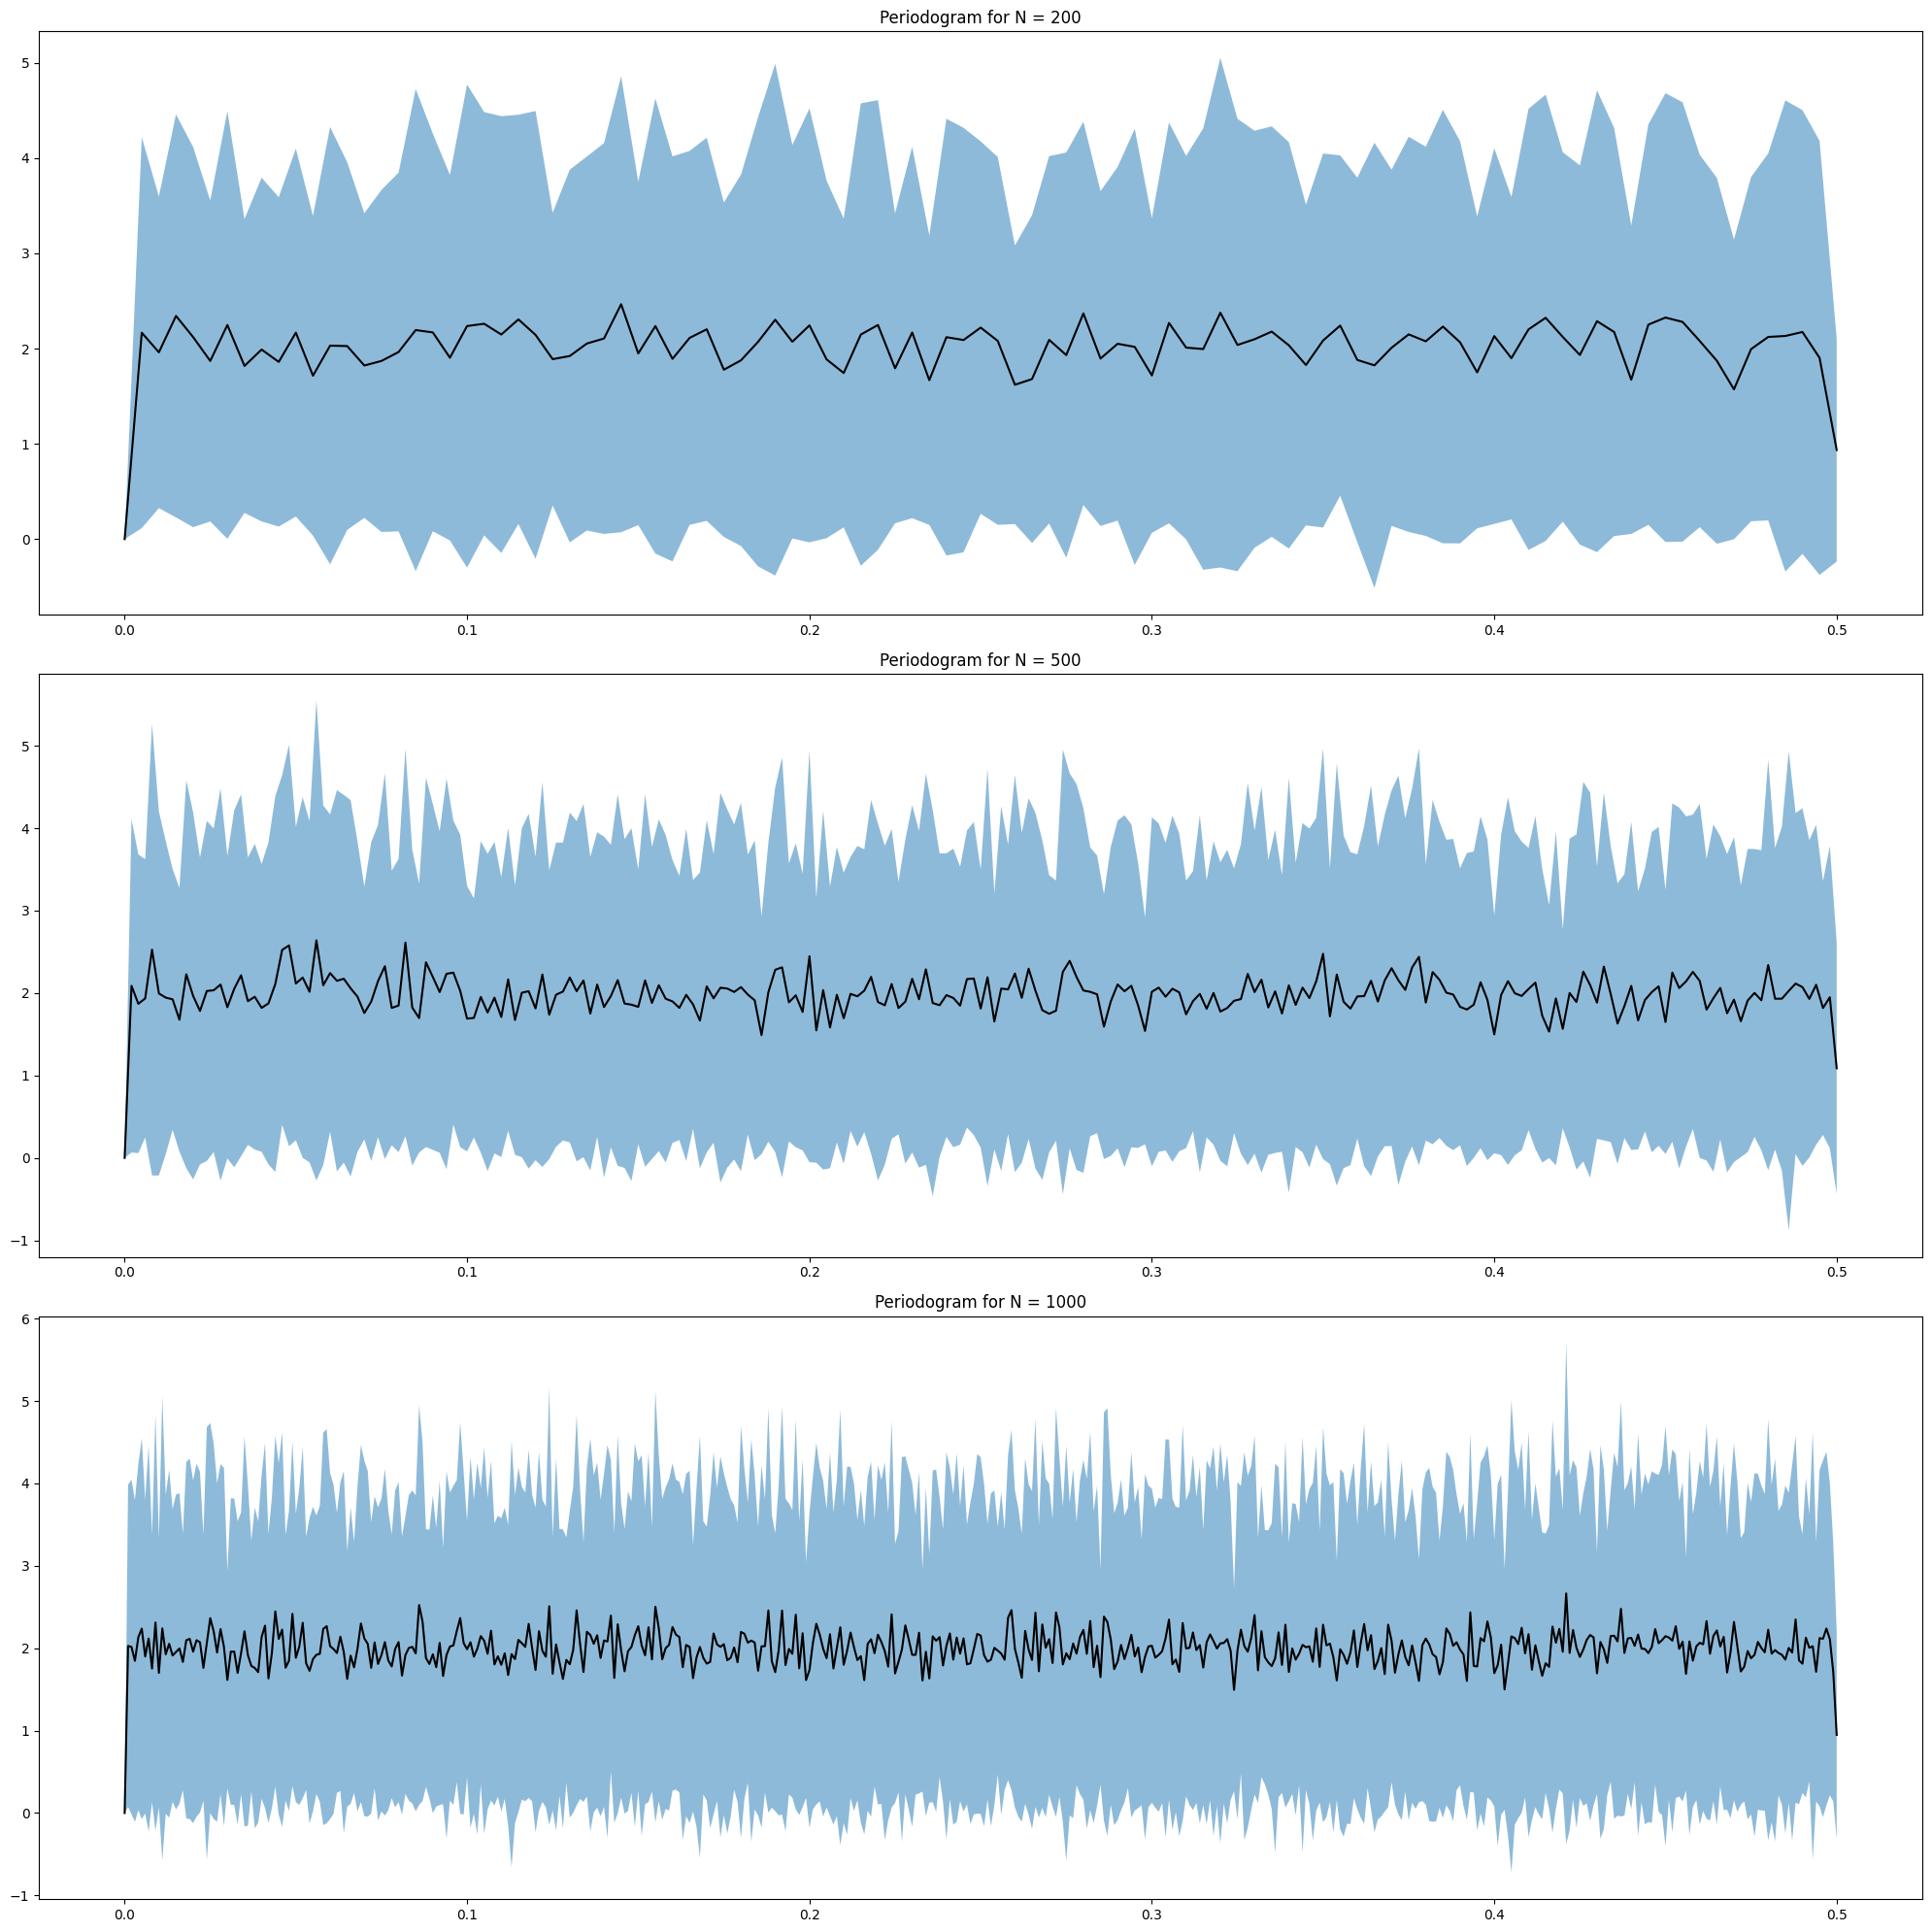

In [5]:
from scipy.signal import periodogram

N = [200, 500, 1000] 
fs = 1
nb_sim = 100 
fig, ax = plt.subplots(3, figsize=(20,20))

# random data 
for ind, size in enumerate(N) : 
    data = np.random.randn(nb_sim, size) 
    fr, power = periodogram(data, fs)
   
    #compute mean and std 
    mean = np.mean(power, 0) 
    std = np.std(power, 0) 

    #plot 
    ax[ind].set_title(f"Periodogram for N = {size}")
    ax[ind].plot(fr, mean, 'k-')
    ax[ind].fill_between(fr, mean-std, mean+std, alpha=0.5)


fig.tight_layout()
plt.show()


## Question 9

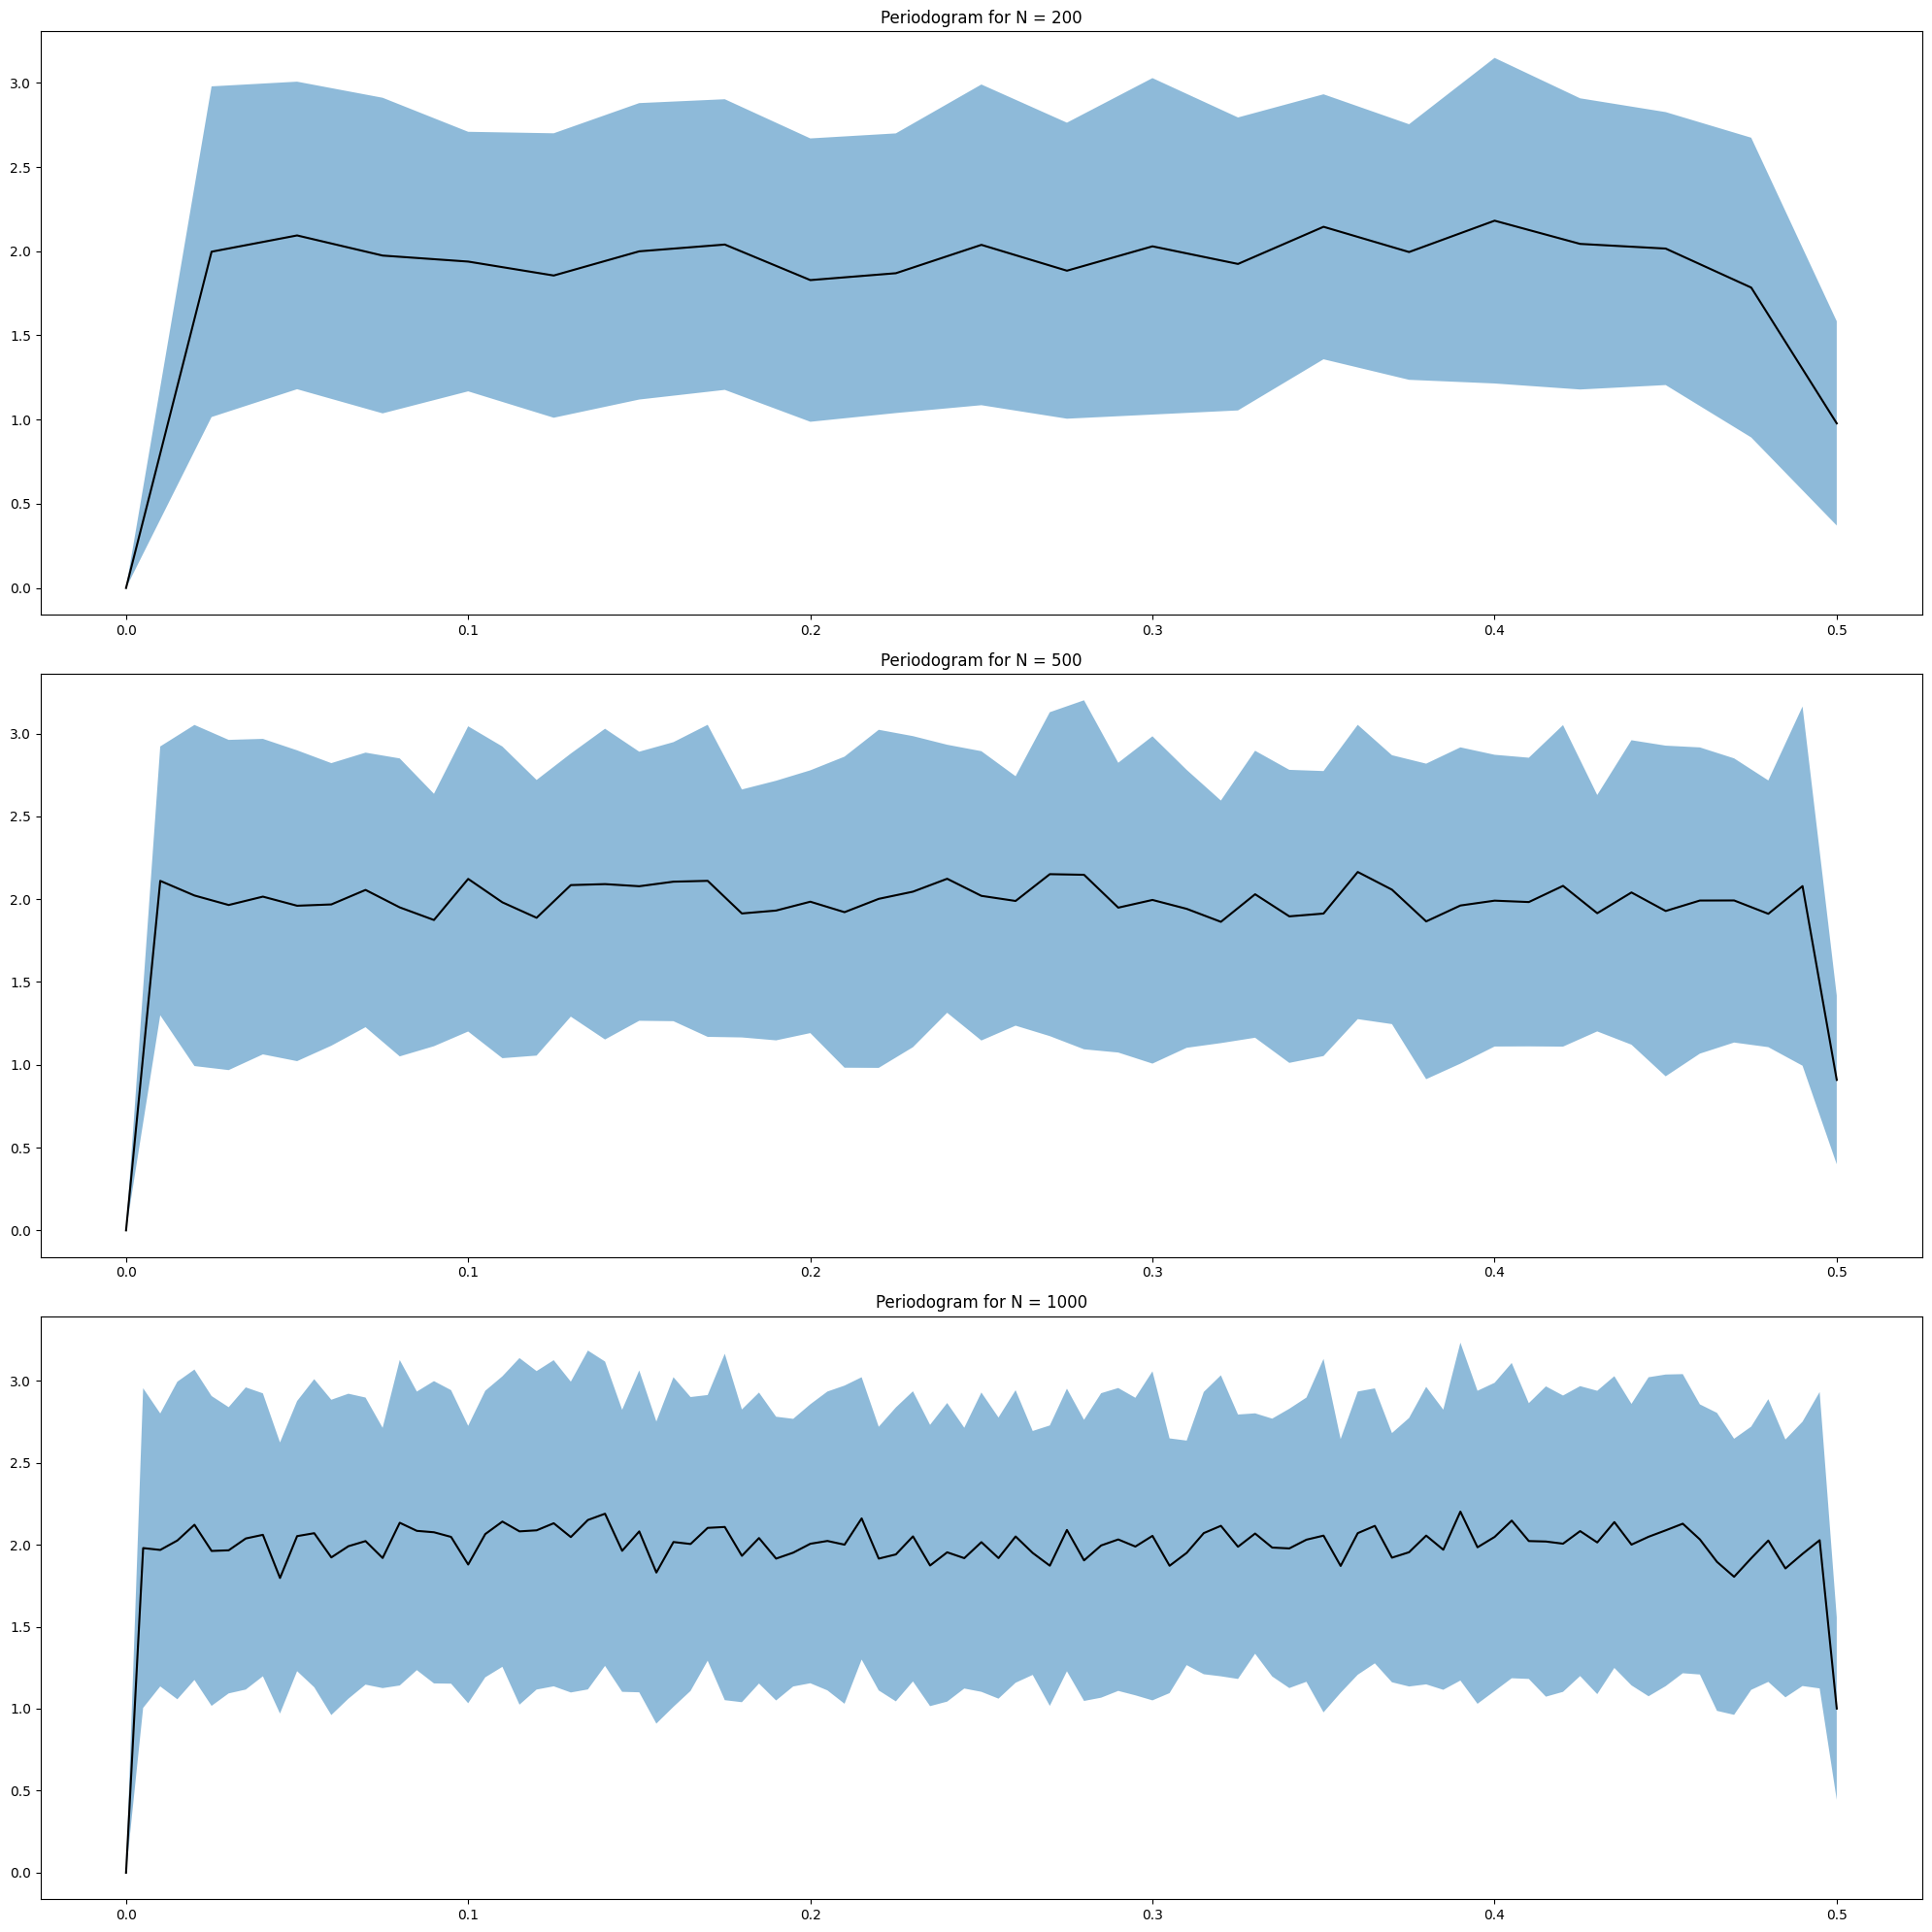

In [6]:
from scipy.signal import periodogram

N = [200, 500, 1000] 
K = 5 
fs = 1
nb_sim = 100 
fig, ax = plt.subplots(3, figsize=(20,20))

# random data 
for ind, size in enumerate(N) : 
    length = int(size / K)
    data = np.random.randn(nb_sim, size) 
    
#split data in K parts 
    data_split = np.zeros(( K, nb_sim, length ))
    perio = np.zeros((K, nb_sim,  int(length/2)+1))

    for i in range(K) : 
        data_split[i] = data[:,i*length:(i+1)*length]
        fr, perio[i] = periodogram(data_split[i], fs)
           
    #compute bartlett estimator 
    bartlett_est = np.mean(perio, 0) 

    #compute mean and std 
    mean = np.mean(bartlett_est, 0) 
    std = np.std(bartlett_est, 0)  


    #plot 
    ax[ind].set_title(f"Periodogram for N = {size}")
    ax[ind].plot(fr, mean, 'k-')
    ax[ind].fill_between(fr, mean-std, mean+std, alpha=0.5)


fig.tight_layout()
plt.show()

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [7]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

Combine the DTW and a k-neighbors classifier to classify each step. Find the optimal number
of neighbors with 5-fold cross-validation and report the optimal number of neighbors and the
associated F-score. Comment briefly.

##### With Sklearn functions

In [8]:
from dtw import dtw 

def dtw_dist(a,b) : 
    return dtw(a, b).distance

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [9]:
def modify_length_sub_list(X) : 
    max_len = 156
    new_X = [np.pad(sub_list, (0, max_len - len(sub_list)), 'constant') for sub_list in X]
    return new_X


In [10]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score

list_k = [i for i in range(2,15)]
nb_fold = 5
scores = []
X_train_array = modify_length_sub_list(X_train)

# cross validation 
kf = KFold(n_splits=nb_fold, shuffle=True, random_state=42)

# test with different k 
for k in list_k:
    knn = KNeighborsClassifier(n_neighbors=k, metric=dtw_dist)
    score = cross_val_score(knn, X_train_array, y_train,  cv=kf, scoring=make_scorer(f1_score, average='weighted'))
    scores.append(np.mean(score))

# find best k 
optimal_k = list_k[np.argmax(scores)]

print(f"Best k : {optimal_k} - Best f1 score = {np.max(scores)}")


Best k : 3 - Best f1 score = 0.8810253429435015


In [11]:
# test with best k and X_test 
knn = KNeighborsClassifier(n_neighbors=optimal_k, metric=dtw_dist)
knn.fit(modify_length_sub_list(X_train), y_train)
pred_label = knn.predict(modify_length_sub_list(X_test))

score_test = f1_score(pred_label, y_test) 

In [12]:
print(f'Score test : {score_test}')

Score test : 0.4778761061946903


## Question 11

Plot a badly classified step from each class (healthy/non-healthy).

In [17]:
from sklearn.metrics import f1_score, confusion_matrix

# test with best k and X_test 
knn = KNeighborsClassifier(n_neighbors=optimal_k, metric=dtw_dist)
knn.fit(modify_length_sub_list(X_train), y_train)
pred_label = knn.predict(modify_length_sub_list(X_test))

score_test = f1_score(pred_label, y_test) 

confusion_matrix(y_test, pred_label)

array([[ 2, 13],
       [46, 27]])

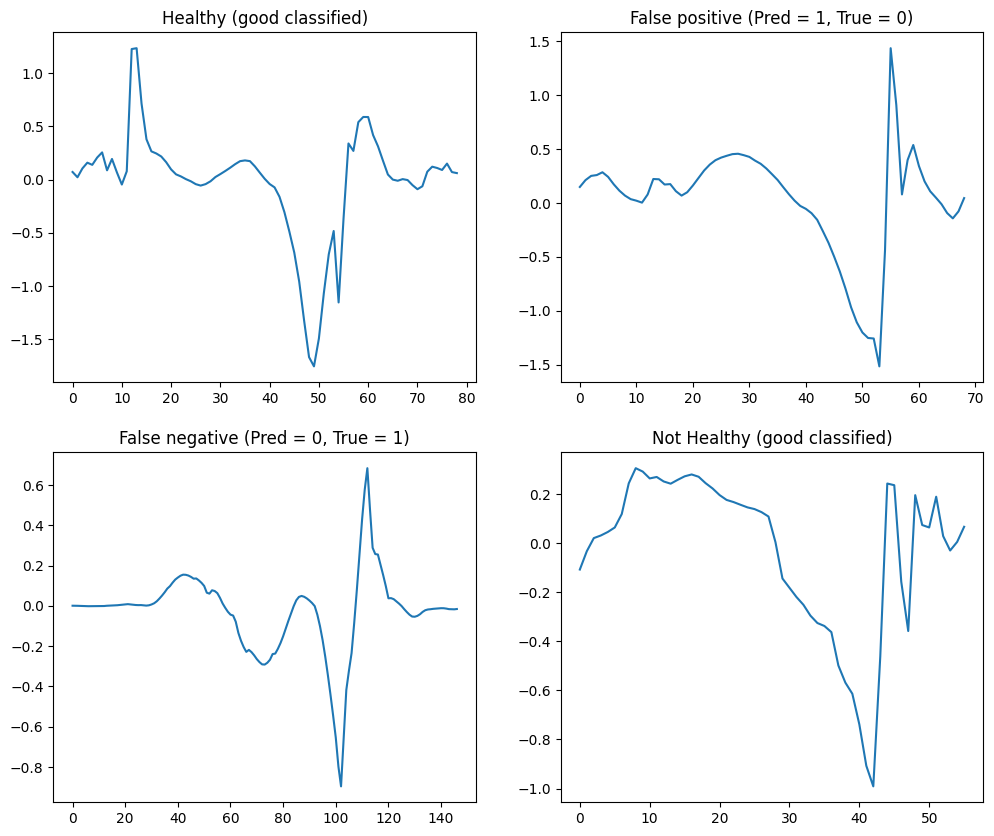

In [18]:
import pandas as pd 

df = pd.DataFrame.from_dict({'true': y_test, 'pred': pred_label, 'data' : X_test})

cond_true_0 = df['true']==0
cond_true_1 = df['true']==1
cond_pred_0 = df['pred']==0
cond_pred_1 = df['pred']==1


false_pos= df[cond_pred_1 & cond_true_0]
false_neg = df[cond_pred_0 & cond_true_1]
true_pos= df[cond_pred_1 & cond_true_1]
true_neg = df[cond_pred_0 & cond_true_0]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].set_title('Healthy (good classified)')
axs[0, 0].plot(true_pos.iloc[0,]['data'])
axs[1, 1].set_title('Not Healthy (good classified)')
axs[1, 1].plot(true_neg.iloc[0,]['data'])
axs[1, 0].set_title('False negative (Pred = 0, True = 1)')
axs[1, 0].plot(false_neg.iloc[0,]['data'])
axs[0, 1].set_title('False positive (Pred = 1, True = 0)')
axs[0, 1].plot(false_pos.iloc[0,]['data'])
